# Try out Bayesian update to environmental estimate

In [1]:
#%%
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
import arviz as az
#%%

In [2]:
rng=np.random.Generator(np.random.PCG64(1234))
#%%
size = 250
mean_tempC_Km = 6.5/1000
max_alt_Km = 13
lat = np.arange(0, size)
long = np.arange(0, size)
alt = np.arange(0, max_alt_Km)*1000
#%%

In [3]:
def sample_AR_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]
#%%


Baseline thermal along latitude

In [4]:
base_sigma = .05
samp_lat= pd.DataFrame(sample_AR_signal(size, 0.5, mu=2, sigma=base_sigma))
# %%

Extend along longitude

In [5]:
samp = sample_AR_signal(size, 0.5, mu=samp_lat, sigma=base_sigma)
samp = pd.DataFrame(samp[:, :, 0])
# %%


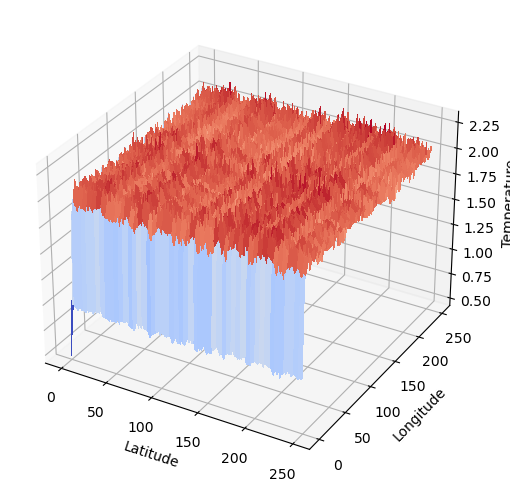

In [6]:
def plot_temperature_env(samp):
    x2, y2 = np.meshgrid(samp.index.values, samp.columns.values)
    plt.figure(figsize=(6,5))
    axes = plt.axes(projection='3d')
    axes.plot_surface(x2, y2,samp.values,cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
    axes.set_ylabel('Longitude')
    axes.set_xlabel('Latitude')
    axes.set_zlabel('Temperature')
# keeps padding between figure elements
    plt.tight_layout()
    plt.show()

plot_temperature_env(samp)

# %%

Add trend on top of the AR variation -- to baseline thermal

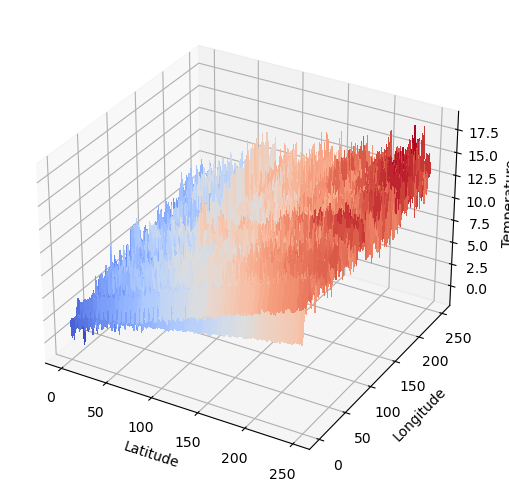

In [7]:
lat_inc_max = 10
long_inc_mu, long_inc_std = .01, .1

def add_inc_MA(size, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std):
    lat_inc = np.linspace(0,lat_inc_max, len(samp_lat))
    sample_lat_inc = samp_lat[0] + lat_inc
    sample_lat_inc = pd.DataFrame(sample_lat_inc)
#sample_lat_inc.plot()

    samp_inc = sample_AR_signal(size, corr=0.5, mu=sample_lat_inc)
    long_inc = stats.norm.rvs(loc=long_inc_mu, scale=long_inc_std, size=(size,size), random_state=None)
    long_inc = np.cumsum(long_inc, axis=0)
    samp_inc = pd.DataFrame(samp_inc[:, :, 0]+long_inc)
    return samp_inc

samp_inc = add_inc_MA(size, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std)


plot_temperature_env(samp_inc)
# %%

Extend into atmosphere

In [8]:
#allow for inversion by having random lapse rate at diff altitudes
def add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km):
    tempC_Km = rng.normal(loc=mean_tempC_Km, scale=mean_tempC_Km/10, size=max_alt_Km)
# Temp at altitude = base temp - tempC_km * altitude
    temperature = ( [np.array(samp_inc) 
                 for _ in np.arange(max_alt_Km)]
               -np.broadcast_to(
    tempC_Km * np.arange(max_alt_Km)*1000, (250,250,13)
    ).T
)
    temperature = temperature.T
    return temperature

temp_3D = add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km)

# %%

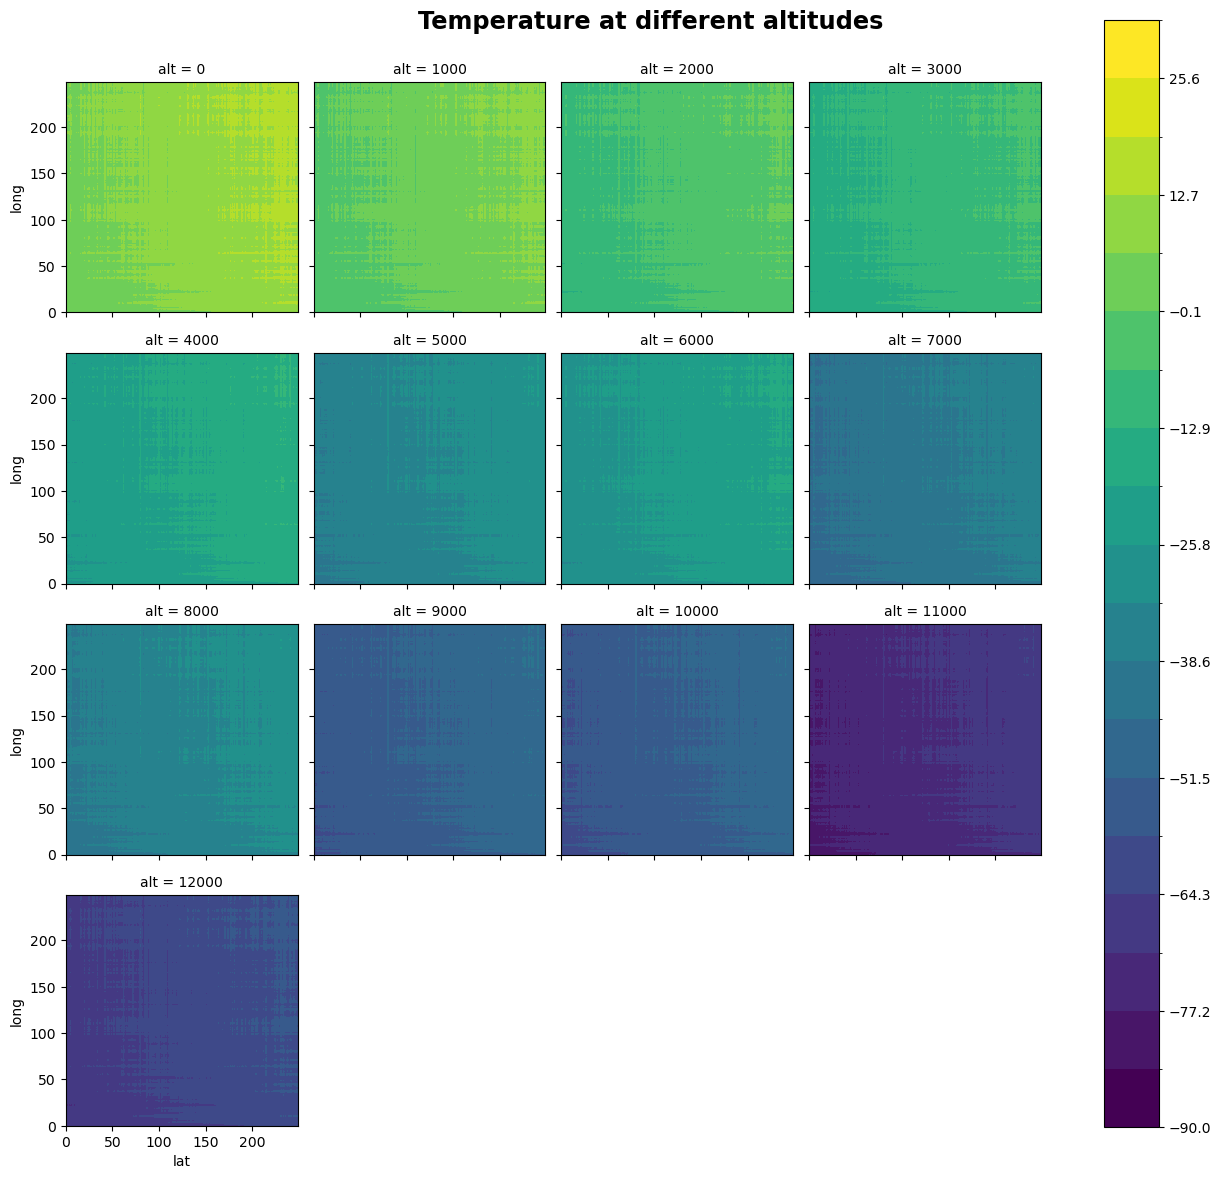

In [9]:
xr_temp_3D = xr.DataArray(temp_3D, dims=['lat', 'long', 'alt'], coords={'lat': lat, 'long': long, 'alt': alt})
fig = xr_temp_3D.plot.contourf(x='lat',y='long',col='alt', col_wrap=4,
                         robust=True, vmin=-90, vmax=32, levels=20)
plt.suptitle('Temperature at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)

xr_tempC_Km=  xr.DataArray(mean_tempC_Km, dims=['alt'], coords={'alt': alt})

Calculate pressure based on baseline temp field and assumed L; 

- []TODO: refactor equation to use the previously calculated temperatures

In [10]:
# %%
#barometric formula
def add_barometric_effects(T = 288.15-273.15, L = 0.0065, H = 0,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598):
    #barometric formula
    #P = P0 * (1 - L * H / T0) ^ (g0 * M / (R * L))
    #P = pressure
    #P0 = pressure at sea level = 101_325.00 Pa
    #L = temperature lapse rate = temperature lapse rate (K/m) in
    #H = altitude (m)
    #T0 = temperature at sea level = reference temperature (K)
    #g0 = gravitational acceleration = gravitational acceleration: 9.80665 m/s2
    #M = molar mass of air = molar mass of Earth's air: 0.0289644 kg/mol
    #R = gas constant = universal gas constant: 8.3144598 J/(mol·K)
    #L = temperature lapse rate
    #T = temperature
    T = T +273.15
    if isinstance(T, xr.core.dataarray.DataArray):
        T0 = T.sel(alt=0)
        
    else:
        T0 = T[0]
        print('used t[0]')
        print(type(T))
    #return P0 * (1 - L * H / (T0+273.15)) ** (g0 * M / (R * L))
    return T / T0 #P0 * (T / T0) ** (g0 / (R * L))


pressure = add_barometric_effects(T = xr_temp_3D, 
                                 L = xr_tempC_Km, 
                                 H = xr_temp_3D.alt,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598)
   

In [11]:
pressure

<xarray.DataArray (lat: 250, long: 250, alt: 13)>
array([[[1.        , 0.97622752, 0.94925773, ..., 0.77589376,
         0.70577275, 0.74093203],
        [1.        , 0.97611144, 0.94900995, ..., 0.77479944,
         0.70433603, 0.739667  ],
        [1.        , 0.9760577 , 0.94889526, ..., 0.77429288,
         0.70367098, 0.73908141],
        ...,
        [1.        , 0.97623589, 0.94927561, ..., 0.77597272,
         0.70587643, 0.74102332],
        [1.        , 0.97620631, 0.94921246, ..., 0.77569384,
         0.70551029, 0.74070093],
        [1.        , 0.97629239, 0.94939621, ..., 0.77650535,
         0.70657571, 0.74163904]],

       [[1.        , 0.97624658, 0.94929842, ..., 0.77607347,
         0.7060087 , 0.74113978],
        [1.        , 0.97614198, 0.94907515, ..., 0.77508737,
         0.70471405, 0.73999985],
        [1.        , 0.97609753, 0.94898028, ..., 0.77466838,
         0.70416397, 0.73951549],
...
        [1.        , 0.97719422, 0.95132115, ..., 0.78500697,
         0.71773741, 0.75146695],
        [1.        , 0.97717546, 0.95128111, ..., 0.78483015,
         0.71750527, 0.75126255],
        [1.        , 0.977248  , 0.95143594, ..., 0.78551396,
         0.71840304, 0.75205304]],

       [[1.        , 0.9766885 , 0.9502417 , ..., 0.78023952,
         0.71147826, 0.74595575],
        [1.        , 0.97681683, 0.95051561, ..., 0.78144926,
         0.71306653, 0.74735422],
        [1.        , 0.97688222, 0.95065519, ..., 0.78206575,
         0.71387591, 0.74806688],
        ...,
        [1.        , 0.97713982, 0.95120503, ..., 0.78449413,
         0.71706411, 0.7508741 ],
        [1.        , 0.97712313, 0.95116941, ..., 0.7843368 ,
         0.71685755, 0.75069223],
        [1.        , 0.97721393, 0.95136322, ..., 0.78519278,
         0.71798136, 0.75168175]]])
Coordinates:
  * lat      (lat) int32 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249
  * long     (long) int32 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249
  * alt      (alt) int32 0 1000 2000 3000 4000 ... 8000 9000 10000 11000 12000

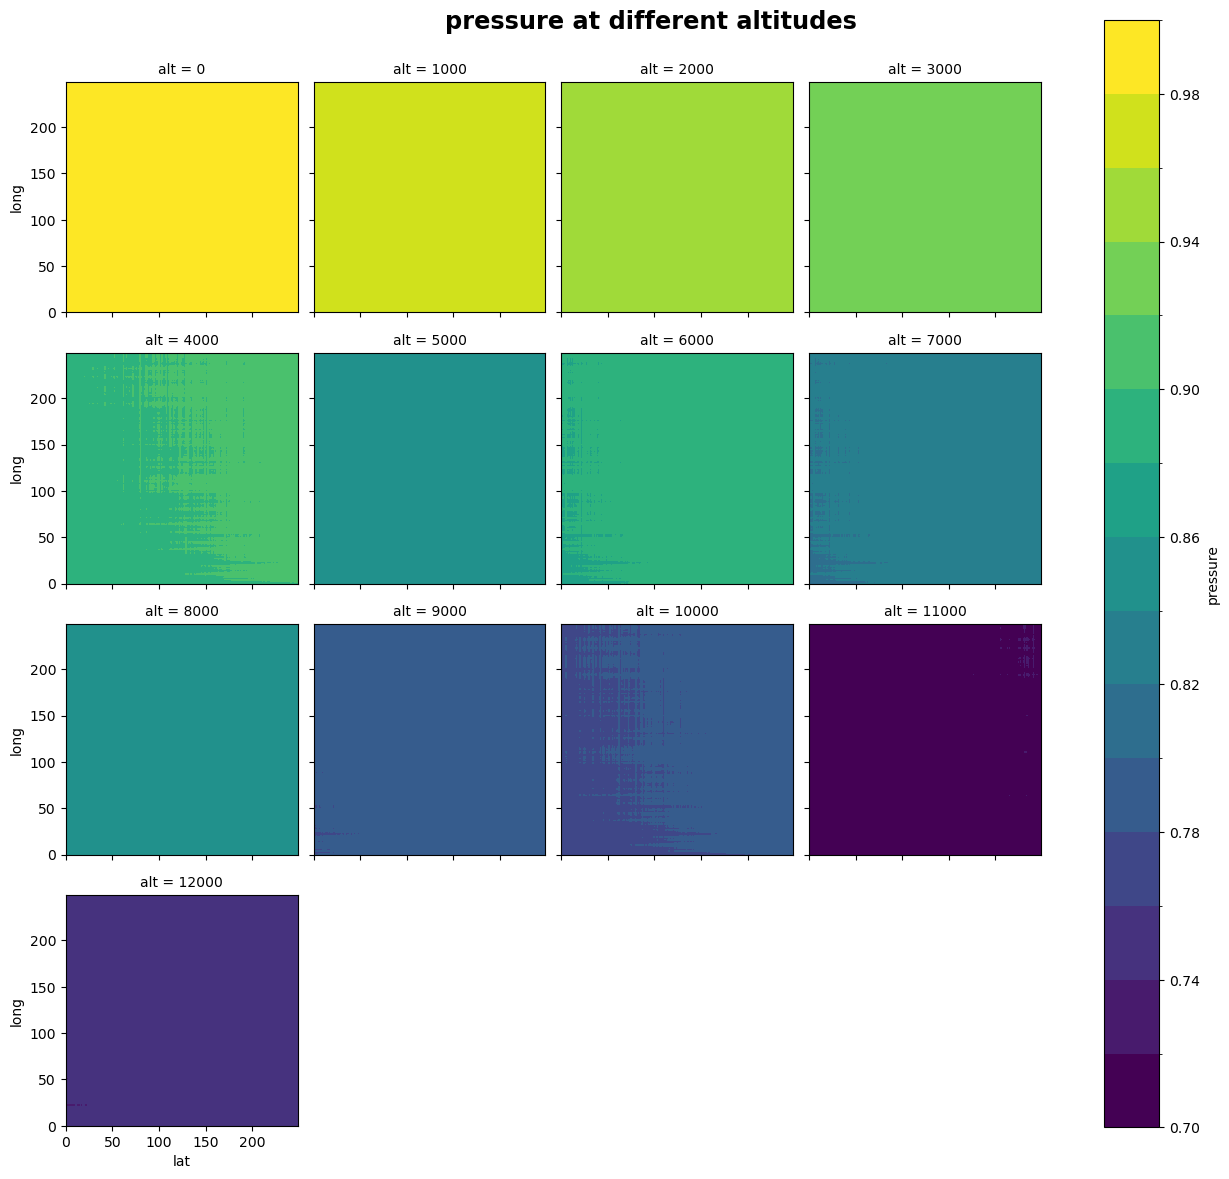

In [12]:
 
# %%
xr_temp_pres = xr.merge(
    [xr_temp_3D.rename("Temperature"), 
     pressure.rename("pressure")]
     )
# %%
xr_temp_pres.pressure.plot.contourf(x='lat',y='long', col='alt', col_wrap=4,
                         robust=True, levels=20)
plt.suptitle('pressure at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)
# %%

# make trajectory and get corresponding temp and pres

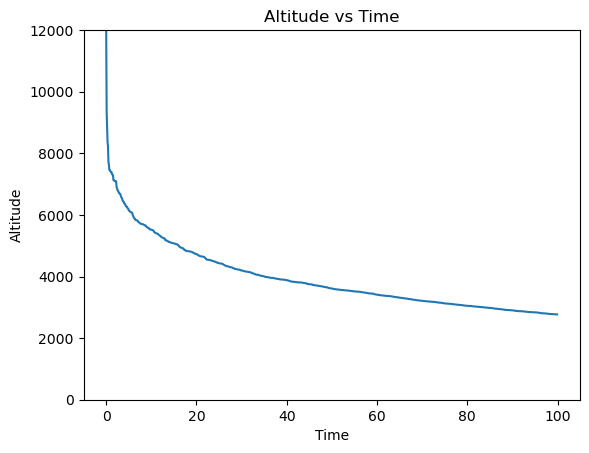

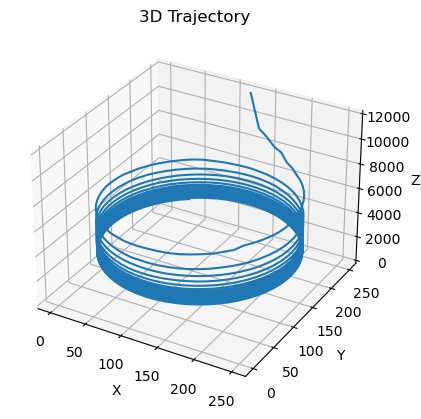

In [13]:
# make Z = a function of time and  X = sin of time and y = cos of time

# %%
time = np.arange(0, 100, 0.1)
release_alt = 12_000 #Troposphere goes to about 12Km, thermal is about linear there
step_alt = 1
x = (np.sin(time) +1) * 250/2
y = (np.cos(time) +1 ) * 250/2
#create samples from normal distribution and sort them
samples = stats.norm.rvs(loc=0, scale=10, size=len(time), random_state=None)
samples = stats.weibull_max.rvs(1, loc=0, scale=1, size=len(time), random_state=None)
samples.sort()
#steps = 1/(1+np.exp(-samples)) #sigmoid function
steps = samples/(samples.max()-samples.min()) /1.3  #normalize
steps = steps - steps.min() #shift to 0
 #smaller step per time
z = release_alt * (1- steps)

plt.plot(time, z)
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude vs Time')
ax = plt.gca()
ax.set_ylim(0, 12000)
plt.show()
#plot 3d trajectory of z by x and y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_zlim(0, 12000)
plt.title('3D Trajectory')
plt.show()
# %%

In [41]:
#select from xarray the temperature at the pressure of the trajectory
xr_x = xr.DataArray(x, dims=['time'], coords={'time': time})
xr_y = xr.DataArray(y, dims=['time'], coords={'time': time})
xr_z = xr.DataArray(z, dims=['time'], coords={'time': time})

xr_traj_env = xr_temp_pres.interp(lat=xr_x,long=xr_y,alt=xr_z, method='nearest')


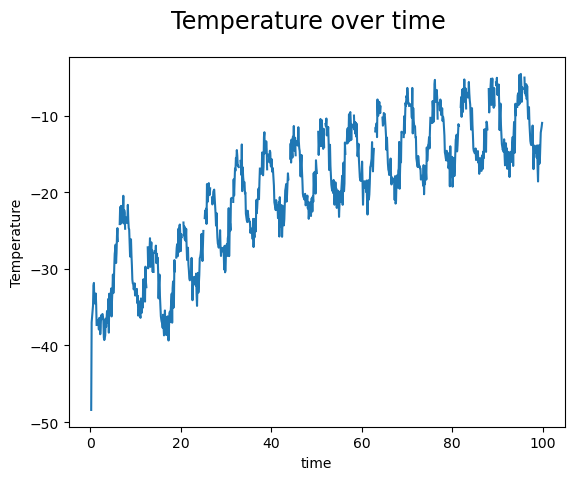

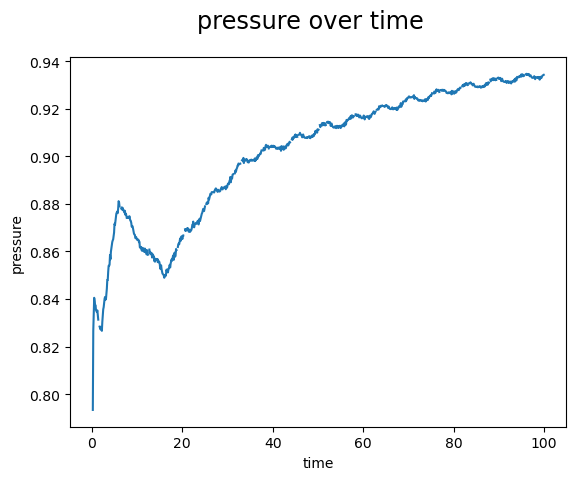

In [15]:
xr_traj_env.Temperature.plot()
plt.suptitle('Temperature over time', fontsize = 'xx-large')
plt.show()
xr_traj_env.pressure.plot()
plt.suptitle('pressure over time', fontsize = 'xx-large')
plt.show()


In [42]:
#add wind direction and speed then its velocity relvant to the trajectory
wind_direction = 180 #degrees from north is 0, from east is 90, from south is 180, from west is 270
wind_speed = 10 #m/s #TODO: add wind speed as a function of altitude and lat long
wind_speed_long = wind_speed * np.cos(np.deg2rad(wind_direction))
wind_speed_lat = wind_speed * np.sin(np.deg2rad(wind_direction))
wind_speed_z = 0
display('wind_speed_long',wind_speed_long, 
        'wind_speed_lat',wind_speed_lat, 
        'wind_speed_z',wind_speed_z)
# %%

'wind_speed_long'

-10.0

'wind_speed_lat'

1.2246467991473533e-15

'wind_speed_z'

0

In [54]:
#add wind velocity relvant to the trajectory
xr_traj_env['wind_speed_long'] = wind_speed_long
xr_traj_env['wind_speed_lat'] = wind_speed_lat
xr_traj_env['wind_speed_z'] = wind_speed_z
xr_traj_env['wind_speed'] = np.sqrt(wind_speed_long**2 + wind_speed_lat**2 + wind_speed_z**2)
xr_traj_env['wind_direction'] = wind_direction
xr_traj_env=xr_traj_env.interpolate_na(dim='time', method='linear', limit=None, use_coordinate=True, fill_value='extrapolate')
xr_traj_env
# %%

<xarray.Dataset>
Dimensions:          (time: 1000)
Coordinates:
    alt              (time) float64 1.2e+04 9.363e+03 ... 2.77e+03 2.769e+03
  * time             (time) float64 0.0 0.1 0.2 0.3 0.4 ... 99.6 99.7 99.8 99.9
    lat              (time) float64 125.0 137.5 149.8 ... 32.68 41.55 51.26
    long             (time) float64 250.0 249.4 247.5 ... 209.3 218.1 225.9
Data variables:
    Temperature      (time) float64 -90.61 -70.6 -50.58 ... -12.3 -11.51 -12.89
    pressure         (time) float64 0.6619 0.724 0.7862 ... 0.9295 0.9297 0.9293
    wind_speed_long  float64 -10.0
    wind_speed_lat   float64 1.225e-15
    wind_speed_z     int32 0
    wind_speed       float64 10.0
    wind_direction   int32 180

# Using average values per Km; TODO: find more principled way to remove autocorrelation 

In [71]:
bins = [i -500 for i in alt] 
bins.append( alt.max() + 500)
bins

[-500,
 500,
 1500,
 2500,
 3500,
 4500,
 5500,
 6500,
 7500,
 8500,
 9500,
 10500,
 11500,
 12500]

In [78]:

#xarray group by bins of altitudes  and calculate mean
grp_traj_env = xr_traj_env.groupby_bins(bins=bins, group='alt').mean(skipna=True)
grp_traj_env

<xarray.Dataset>
Dimensions:          (alt_bins: 13)
Coordinates:
  * alt_bins         (alt_bins) object (-500, 500] ... (11500, 12500]
Data variables:
    Temperature      (alt_bins) float64 nan nan nan -11.72 ... nan nan -90.61
    pressure         (alt_bins) float64 nan nan nan 0.9296 ... nan nan 0.6619
    wind_speed_long  (alt_bins) float64 nan nan nan -10.0 ... nan nan -10.0
    wind_speed_lat   (alt_bins) float64 nan nan nan ... nan nan 1.225e-15
    wind_speed_z     (alt_bins) float64 nan nan nan 0.0 0.0 ... 0.0 nan nan 0.0
    wind_speed       (alt_bins) float64 nan nan nan 10.0 ... 10.0 nan nan 10.0
    wind_direction   (alt_bins) float64 nan nan nan 180.0 ... nan nan 180.0

In [86]:
#my_struct=my_struct.assign_coords({'coordA':('coordA',new_values,my_struct.coordA.attrs)})
grp_traj_env= grp_traj_env.assign_coords({'alt_bins':('alt',alt)}).swap_dims({'alt_bins':'alt'})


In [88]:
!!conda install -c conda-forge python-graphviz

['Collecting package metadata (current_repodata.json): ...working... done',
 'Solving environment: ...working... done',
 '',
 '',
 '==> WARNING: A newer version of conda exists. <==',
 '  current version: 4.13.0',
 '  latest version: 23.3.1',
 '',
 'Please update conda by running',
 '',
 '    $ conda update -n base -c defaults conda',
 '',
 '',
 '',
 '## Package Plan ##',
 '',
 '  environment location: c:\\Users\\willi\\OneDrive\\Documents\\GitHub\\Weather\\.conda',
 '',
 '  added / updated specs:',
 '    - python-graphviz',
 '',
 '',
 'The following packages will be downloaded:',
 '',
 '    package                    |            build',
 '    ---------------------------|-----------------',
 '    cairo-1.16.0               |    hdecc03f_1015         1.5 MB  conda-forge',
 '    expat-2.5.0                |       h63175ca_1         221 KB  conda-forge',
 '    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge',
 '    font-ttf-inconsolata-3.000 |       h77eed37_

In [87]:
with pm.Model(coords = {'Alt': np.flip(np.unique(xr_traj_env.alt.values))}) as thermal:
    #Temp is in celcius
    
    Alt_ = pm.ConstantData('Altitude_m', (np.unique(xr_traj_env.alt.values)), dims='Alt' )
    Temp_ = pm.ConstantData('Temperature_Samples', xr_traj_env.Temperature.groupby('alt').mean().values, dims='Alt' )
    #prior on effect of altitude on temp
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=6, sigma=1)
    #prior on temp
    #TODO: PULL FROM DATABASE into a pm.Interpolated
    #mu = hierarchical_normal('temperature_mean', mu= 0.0 - Alt_effect_temp/1000 * Alt_, sigma = 1, dims='Alt')
    mu = pm.Normal('temperature_mean', mu= 0.0 - Alt_effect_temp/1000 * Alt_, sigma = 1, dims='Alt')
    
    #prior on error variation
    sigma=pm.Exponential('model_error', 1/0.5)
    #adjusted temp - normal dist error term
    obs = pm.Normal('obs', mu=mu, sigma=sigma, 
                    observed = Temp_, dims='Alt')
pm.model_to_graphviz(thermal)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

In [63]:
(np.unique(grp_traj_env.alt_bins.values))

array([Interval(0, 1000, closed='right'),
       Interval(1000, 2000, closed='right'),
       Interval(2000, 3000, closed='right'),
       Interval(3000, 4000, closed='right'),
       Interval(4000, 5000, closed='right'),
       Interval(5000, 6000, closed='right'),
       Interval(6000, 7000, closed='right'),
       Interval(7000, 8000, closed='right'),
       Interval(8000, 9000, closed='right'),
       Interval(9000, 10000, closed='right'),
       Interval(10000, 11000, closed='right'),
       Interval(11000, 12000, closed='right')], dtype=object)

In [ ]:
with pm.Model(coords = {'Alt': np.flip(np.unique(xr_traj_env.alt_bins.values))}) as thermal:
    #Temp is in celcius
    
    Alt_ = pm.ConstantData('Altitude_m', (np.unique(xr_traj_env.alt.values)), dims='Alt' )
    Temp_ = pm.ConstantData('Temperature_Samples', xr_traj_env.Temperature.groupby('alt').mean().values, dims='Alt' )
    #prior on effect of altitude on temp
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=6, sigma=1)
    #prior on temp
    #TODO: PULL FROM DATABASE into a pm.Interpolated
    #mu = hierarchical_normal('temperature_mean', mu= 0.0 - Alt_effect_temp/1000 * Alt_, sigma = 1, dims='Alt')
    mu = pm.Normal('temperature_mean', mu= 0.0 - Alt_effect_temp/1000 * Alt_, sigma = 1, dims='Alt')
    
    #prior on error variation
    sigma=pm.Exponential('model_error', 1/0.5)
    #adjusted temp - normal dist error term
    obs = pm.Normal('obs', mu=mu, sigma=sigma, 
                    observed = Temp_, dims='Alt')
pm.model_to_graphviz(thermal)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

Sampling: [Alt_effect_temp_Km, model_error, obs, temperature_mean]


<Axes: xlabel='obs / obs'>

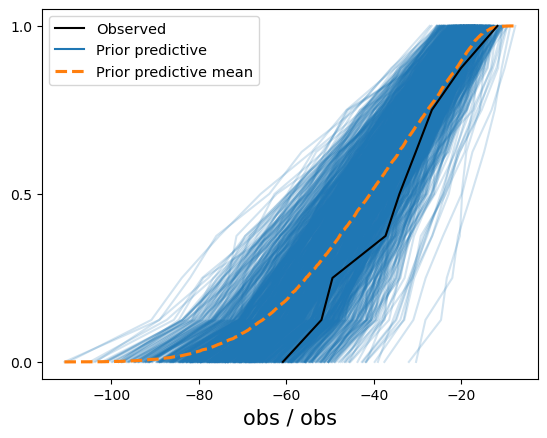

In [ ]:
with thermal:
    idata = pm.sample_prior_predictive(1000)
az.plot_ppc(idata, group='prior', kind='cumulative')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alt_effect_temp_Km, temperature_mean, model_error]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 67 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int32 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int32 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int32 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int32 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


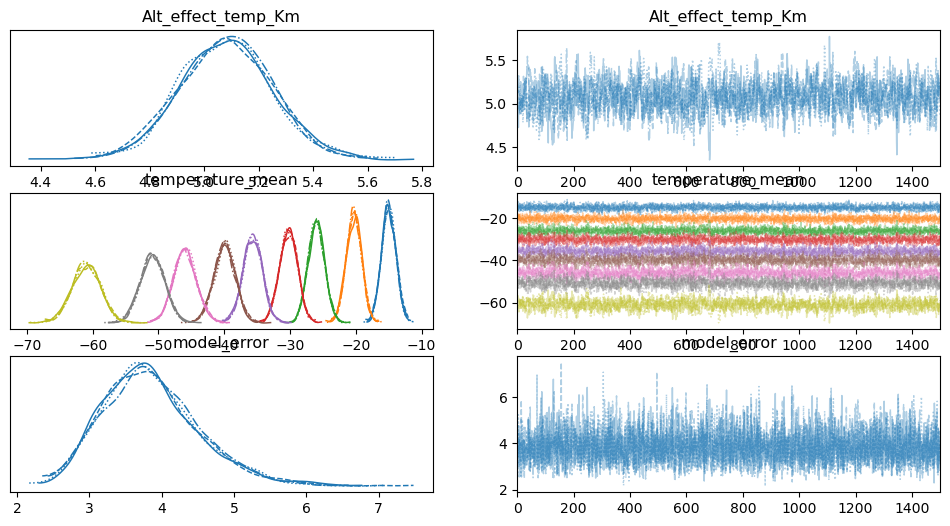

In [ ]:
with thermal:
    idata.extend(pm.sample(1500, tune=1500,  target_accept=.96))
    az.plot_trace(idata)

# Tryout pressure and altitude

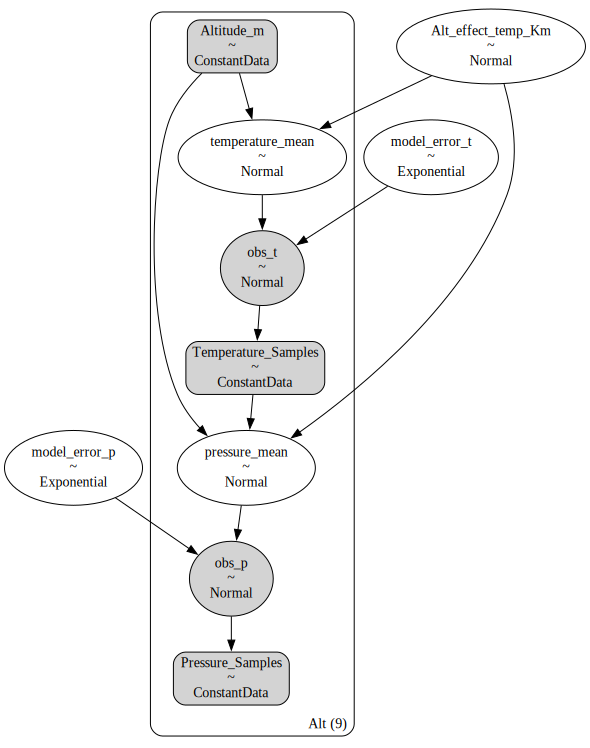

In [ ]:
with pm.Model(coords = {'Alt': np.unique(xr_traj_env.alt.values)}) as thermal_pres:
    #Temp is in celcius
    
    Alt_ = pm.ConstantData('Altitude_m', (np.unique(xr_traj_env.alt.values)), dims='Alt' )
    Temp_ = pm.ConstantData('Temperature_Samples', xr_traj_env.Temperature.groupby('alt').mean().values, dims='Alt' )
    Pres_ = pm.ConstantData('Pressure_Samples', xr_traj_env.pressure.groupby('alt').mean().values, dims='Alt' )
    #prior on effect of altitude on temp
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=6, sigma=1)
    #prior on temp
    #TODO: PULL FROM DATABASE into a pm.Interpolated
    mu_t = pm.Normal('temperature_mean', mu= 0.0 - Alt_effect_temp/1000 * Alt_, sigma = 2, dims='Alt')
    mu_p = pm.Normal('pressure_mean', mu= add_barometric_effects(T = Temp_, 
                                 L = Alt_effect_temp/1000, 
                                 H = Alt_,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598),
                               sigma = 10_000, dims='Alt')
    #P0 * (1 - L * H / (T0+273.15)) ** (g0 * M / (R * L))
    #prior on error variation
    sigma_t=pm.Exponential('model_error_t', 1/0.5)
    sigma_p=pm.Exponential('model_error_p', 1/1000)
    #adjusted temp - normal dist error term
    obs_t = pm.Normal('obs_t', mu=mu_t, sigma=sigma_t, 
                    observed = Temp_, dims='Alt')
    obs_p = pm.Normal('obs_p', mu=mu_p, sigma=sigma_p, 
                    observed = Pres_, dims='Alt')
pm.model_to_graphviz(thermal_pres)

Sampling: [Alt_effect_temp_Km, model_error_p, model_error_t, obs_p, obs_t, pressure_mean, temperature_mean]


array([<Axes: xlabel='obs_t / obs_t'>, <Axes: xlabel='obs_p / obs_p'>],
      dtype=object)

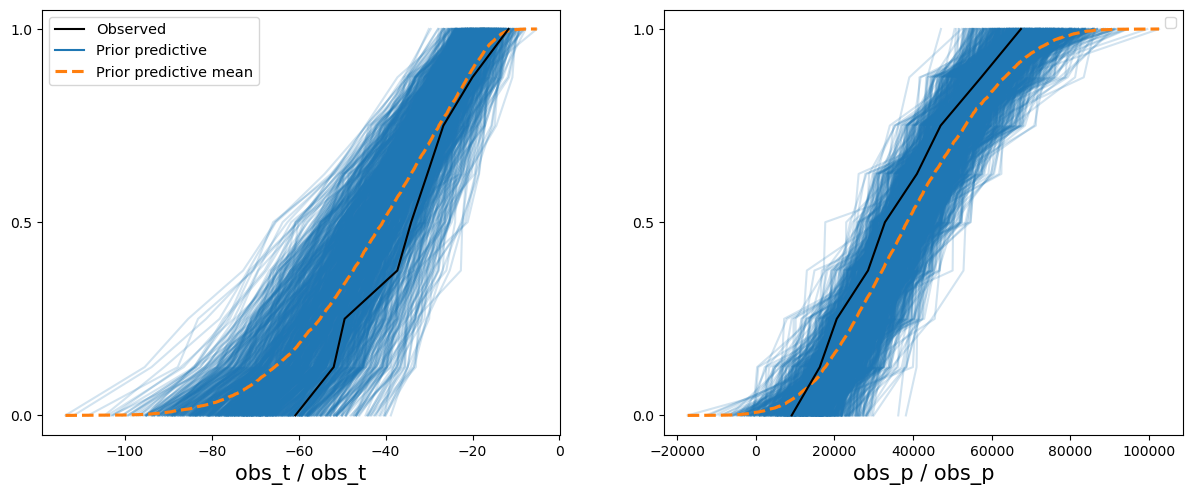

In [ ]:
with thermal_pres:
    idata2 = pm.sample_prior_predictive(1000)
az.plot_ppc(idata2, group='prior', kind='cumulative')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alt_effect_temp_Km, temperature_mean, pressure_mean, model_error_t, model_error_p]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int32 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int32 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int32 2 reached the maximum tree dept

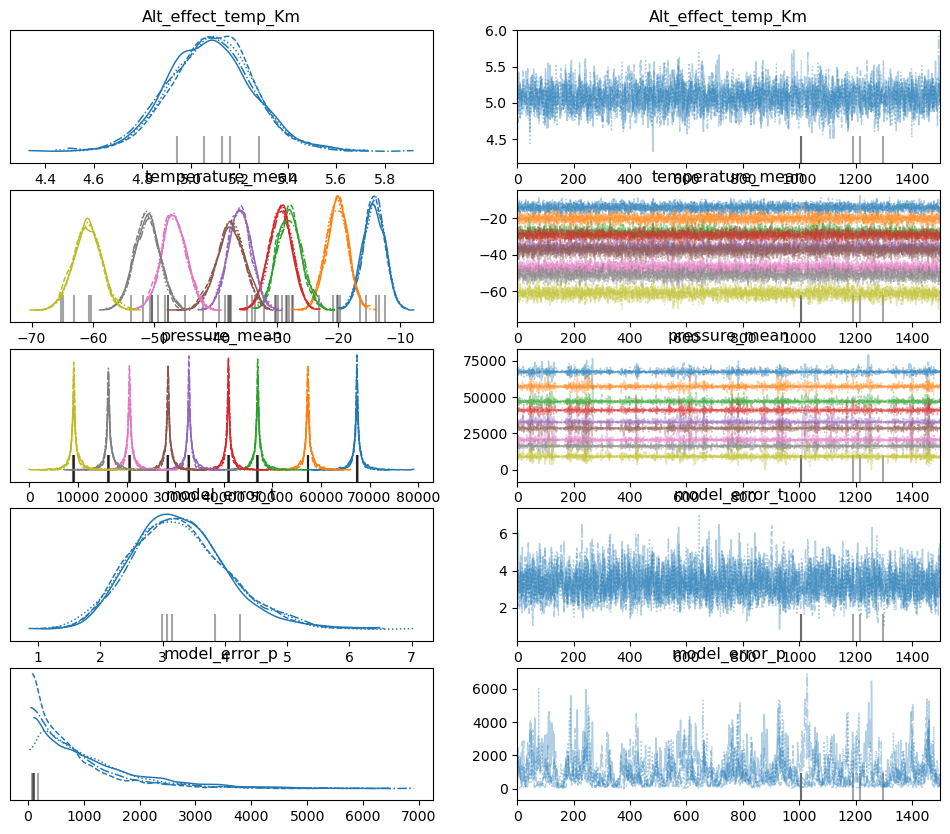

In [ ]:
with thermal_pres:
    idata2.extend(pm.sample(1500, tune=1500, target_accept=.96))
    az.plot_trace(idata2)

array([<Axes: >], dtype=object)

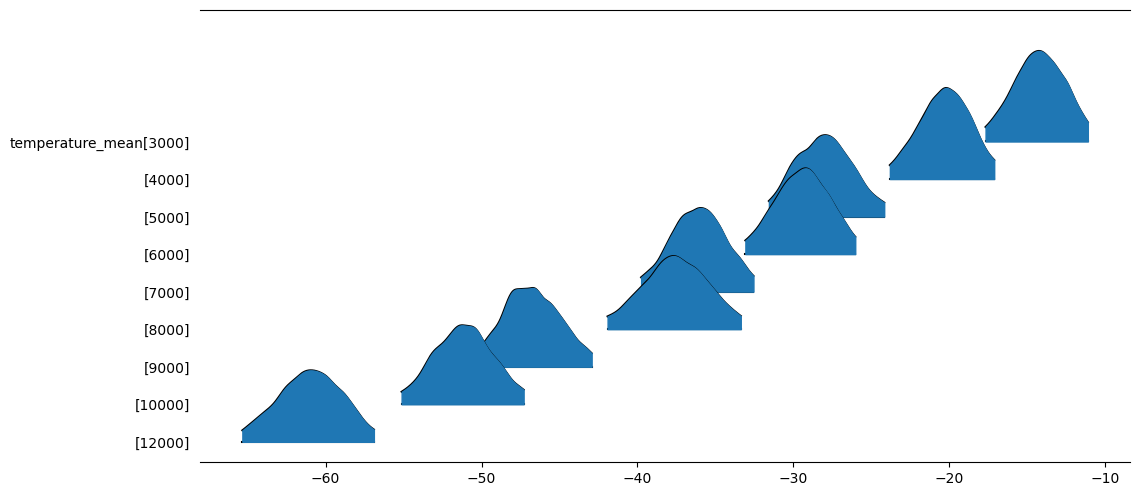

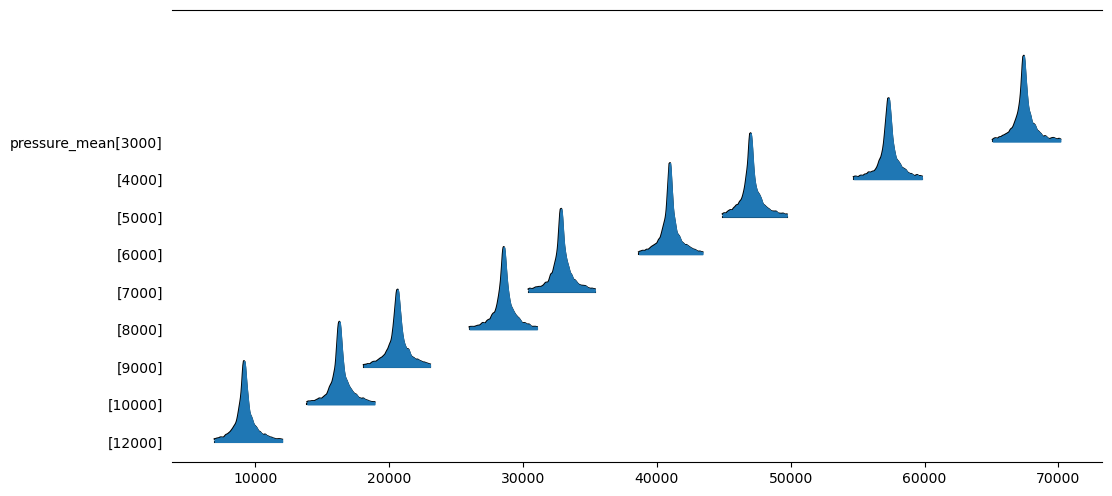

In [ ]:
az.plot_forest(idata2, var_names=['temperature_mean'],kind='ridgeplot', combined=True)
az.plot_forest(idata2, var_names=['pressure_mean'],kind='ridgeplot', combined=True)